In [35]:
from preprocessing import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
import numpy as np

In [2]:
data = "./data/data_for_student_case.csv"
df = pd.read_csv(data)

# I. Data Pre-Processing

## Re-Label

Column `simple_journal` has the payment status.

`relabel()`:
- drops rows which have `simple_journal` = "Refused", since we are not sure whether it was fraud.
- replaces `simple_journal` = "Chargeback" with `1`, i.e. fraud.
- replaces `simple_journal` = "Settled" with `0`, i.e. not fraud.

In [12]:
df = relabel(df)

non_fraud_count = df[df["simple_journal"] == 0].shape[0]
fraud_count = df[df["simple_journal"] == 1].shape[0]
print(f"Class Distribution: label 1 = {fraud_count/df.shape[0]}, label 0 = {non_fraud_count/df.shape[0]}")

Class Distribution: label 1 = 0.00145547511770364, label 0 = 0.9985445248822964


## Check for NaNs

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237036 entries, 0 to 290381
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   txid                          237036 non-null  int64  
 1   bookingdate                   237036 non-null  object 
 2   issuercountrycode             237032 non-null  object 
 3   txvariantcode                 237036 non-null  object 
 4   bin                           237036 non-null  float64
 5   amount                        237036 non-null  float64
 6   currencycode                  237036 non-null  object 
 7   shoppercountrycode            236694 non-null  object 
 8   shopperinteraction            237036 non-null  object 
 9   simple_journal                237036 non-null  object 
 10  cardverificationcodesupplied  223842 non-null  object 
 11  cvcresponsecode               237036 non-null  int64  
 12  creationdate                  237036 non-nul

## Remove NaNs from `issuercountrycode`, `shoppercountrycode` and `cardverificationcodesupplied`

We replace NaN with `False` for `cardverificationcodesupplied` since we assume missing value means card verification code was not supplied.

Rest are replaced with dummy values which we numerically encode below

In [14]:
df = replace_na_with(df, "cardverificationcodesupplied", False)
df = replace_na_with(df, "issuercountrycode", "ZZ")
df = replace_na_with(df, "shoppercountrycode", "ZZ")

## Remove NaN in `mail_id`

The NaNs in `mail_id` column are strings "na", which we replace with dummy value "email99999" and later encode it numerically

In [22]:
df.loc[df["mail_id"].str.contains("na", case=False), "mail_id"] = "email99999"

## Convert `creationdate` and `bookingdate` to a pandas datetime object

This allows more flexibility later for date wise aggregation using datetime functions

In [23]:
df["creationdate"] = pd.to_datetime(df["creationdate"])
df["date"] = df["creationdate"].dt.date

df["bookingdate"] = pd.to_datetime(df["bookingdate"])

## Encode `issuecountrycode` and `shoppercountrycode`

- First we create a country code list that encapsulates both shopper and issue country codes
- Then we encode `issuecountrycode` and `shoppercountrycode` using this full list

In [17]:
unique_issuer_cc = df["issuercountrycode"].unique().tolist()
unique_shopper_cc = df["shoppercountrycode"].unique().tolist()
unique_codes = list(set(unique_issuer_cc + unique_shopper_cc))
df, issuer_country_enc = encode(df, "issuercountrycode", values=unique_codes)
df, shopper_country_enc = encode(df, "shoppercountrycode", values=unique_codes)

## Convert transaction amount in `amount` to EUR

- The transaction amount in the `amount` column is in the currency according to the `currencycode` column
- We convert all transaction amounts to euros using a fixed exchange rate

In [18]:
df["amount_eur"] = df.apply(lambda x: conv_to_eur(x), axis=1)

## Replace `accountcode` with the respective Country Code

In [21]:
df["accountcode"] = df["accountcode"].apply(lambda x: re.sub("Account", "", x))
df["accountcode_cc"] = 0
df.loc[(df["accountcode"] == "UK"), "accountcode_cc"] = "GB"
df.loc[(df["accountcode"] == "Mexico"), "accountcode_cc"] = "MX"
df.loc[(df["accountcode"] == "Sweden"), "accountcode_cc"] = "SE"
df.loc[(df["accountcode"] == "APAC"), "accountcode_cc"] = "APAC"
df.drop(["accountcode"], axis=1, inplace=True)

## Replace all `cvcresponsecode` values above 2 with a single value

`cvcresponsecode` 3 - 6 correspond to not checked

In [24]:
df.loc[df["cvcresponsecode"] > 2, "cvcresponsecode"] = 3

## Numerical Encoding of categorical columns

We can replace the categorical columns with positive integers, since we need numbers to input to the ML Model

In [41]:
df, card_enc = encode(df, "card_id")
df, ip_enc = encode(df, "ip_id")
df, tx_var_enc = encode(df, "txvariantcode")
df, shop_enc = encode(df, "shopperinteraction")
df, card_verif_enc = encode(df, "cardverificationcodesupplied")
df, email_enc = encode(df, "mail_id")
df, currency_enc = encode(df, "currencycode")
df, account_cc_enc = encode(df, "accountcode_cc")

# II. Visualization

## Heatmap

Put explanation here

Text(0.5, 1.0, 'Normal')

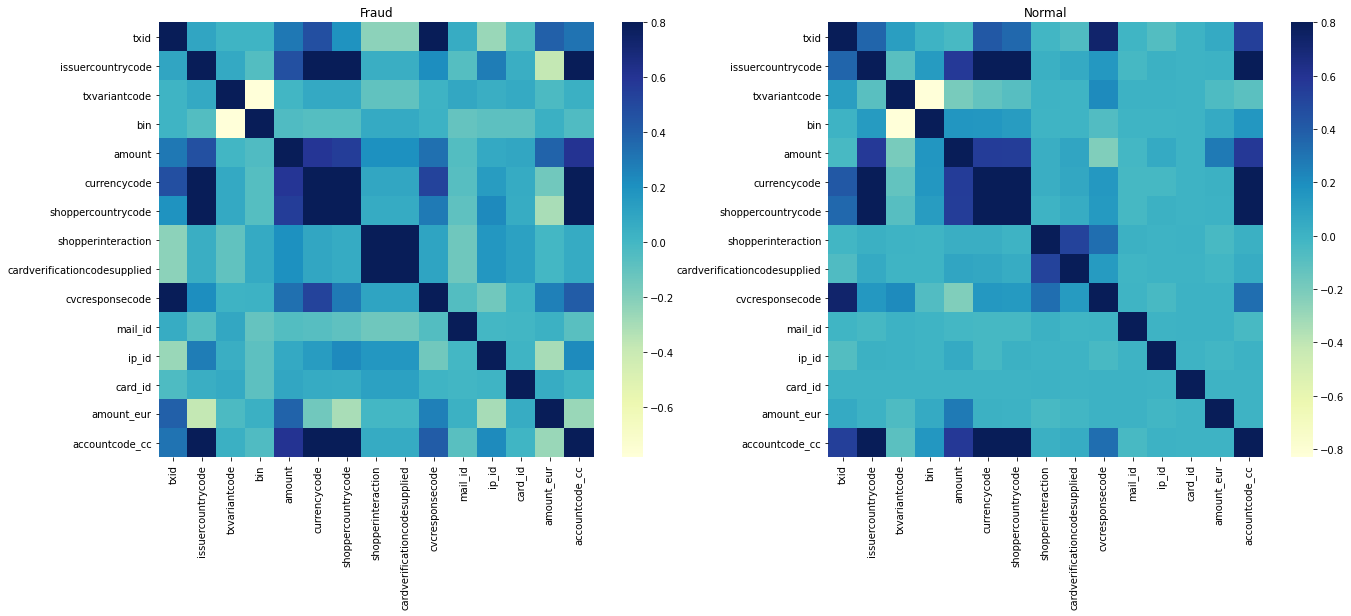

In [42]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1,2,figsize =(22, 8))

sns.heatmap(df.query('simple_journal==1').corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df.query('simple_journal==0').corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

# plt.show()

## Absolute Difference in Correlation
Put Explanation here

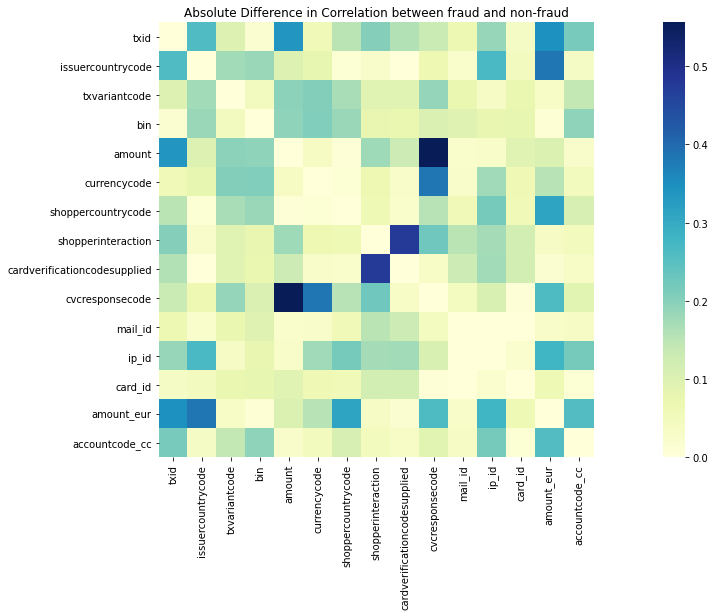

In [43]:
f, (ax1) = plt.subplots(1,figsize =(25, 8))
abs_diff_in_corr = np.abs(df.query('simple_journal==0').corr() - df.query('simple_journal==1').corr())
# print(abs_diff_in_corr)
sns.heatmap(abs_diff_in_corr, square=True, cmap = 'YlGnBu')
ax1.set_title('Absolute Difference in Correlation between fraud and non-fraud')
plt.show()

## Isomap

Put explanation here

TODO: Does not run on 8GB RAM. Need to fix this

In [ ]:
fraud_index = np.where(df['simple_journal'] == 1)[0]

not_fraud_index = np.where(df['simple_journal'] == 0)[0]
not_fraud_index = np.random.choice(not_fraud_index, size= int (0.01*len(not_fraud_index)), replace=False)
columns = ['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','mail_id','accountcode_cc','ip_id','card_id','amount_eur']
X = df[columns]
isomap = Isomap(n_components=2, n_jobs=-1, neighbors_algorithm='kd_tree')
isomap.fit(X.iloc[np.union1d(fraud_index, not_fraud_index), :])
df_embedded = isomap.transform(X)
df_embedded.shape

In [ ]:
X_embedded = PCA(n_components=2).fit_transform(X)
fraud_index = np.where(df['simple_journal'] == 1)[0]

not_fraud_index = np.where(df['simple_journal'] == 0)[0]
not_fraud_index = np.random.choice(not_fraud_index, size= int (0.1*len(not_fraud_index)), replace=False)

fig = plt.figure(figsize=(10,8))
plt.scatter(X_embedded[not_fraud_index, 0], X_embedded[not_fraud_index, 1], c='b', alpha=0.4)
plt.scatter(X_embedded[fraud_index, 0], X_embedded[fraud_index, 1], c='r')
plt.show()

# III. Feature Extraction

In [ ]:
df["countries_equal"] = df["shoppercountrycode"] == df["issuercountrycode"]
df.loc[df["countries_equal"] == False, "countries_equal"] = 0
df.loc[df["countries_equal"] == True, "countries_equal"] = 1

In [ ]:
df["day_of_week"] = df["creationdate"].dt.dayofweek
df["hour"] = df["creationdate"].dt.hour